## Initialization (#init)

The following is a script for replicating figures and tables presented in paper "Reasoning about Regular Properties: A Comparative Study"

Run `Cell` -> `Run All` to generate files in `figs/` directory. See the `README` for more information about the context of the work.

The first cell initializes the notebook and helpers.

In [1]:
import pandas
import tabulate
import pickle
import seaborn
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import csv
import re
import numpy as np
import itertools
from statistics import mean
from collections import defaultdict
from enum import Enum
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

# Short hack for display of images in jupyter notebook

from IPython.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

# Since, we measured in virtual machine, and had some movements of benchmarks between partitions, 
# we need to unify the paths between different/path measurings
PREFIX = "/home/debian/bench/"
PREFIX2 = "/home/debian/home1/bench/"
PREFIX3 = "/home1/debian/bench/"

def is_real(x):
    """Determines, whether `x` corresponds to real value"""
    try:
        float(x)
        return True
    except ValueError:
        return False        

def value_to_float(val, timeout):
    """Converts @p val to timeout or NaN"""
    if val.startswith('TO') or val == 'ERR':
        return timeout
    else:
        return np.NaN
    
def to_float_with_timeout(series, timeout):
    """Converts @p series to floats or timeouts"""
    return [float(f) if is_real(f) else value_to_float(f, timeout) for f in series]

def df_to_float(df, timeout, allow_timeouts=False):
    """Transforms @p df to dataframe with floats only, timeouts are either converted to NaN or to @p timeout"""
    return df.apply(lambda x: to_float_with_timeout(x, timeout)).dropna(how='all', axis='columns')

def unify_tool(tool):
    """Unifies the names of the tool
    
    This is due to the fact, that we tried different parameters in past and need to unify it in the data
    """
    return tool_to_output[
        tool.replace('-runtime','').replace('-backward','-bwd').replace('-nt','').replace('-min','').replace('-incl','')
    ]
        
def get_benchmark_name(bench):
    """Returns classification for @p bench benchmark"""
    if 'bool_comb/ere/QF_SLIA_Norn' in bench or 'bool_comb/ere/QF_S_sygus_qgen' in bench:
        return 'b-smt'
    elif 'email_filter' in bench:
        return 'b-regex'
    elif 'bool_comb/ere/boolean_and_loops' in bench or 'bool_comb/ere/date' in bench or 'bool_comb/ere/det_blowup' in bench or 'bool_comb/ere/password' in bench:
        return 'b-hand-made'
    elif 'armc-inclusion' in bench or "automata_inclusion" in bench:
        return 'b-armc-incl'
    elif 'bool_comb/cox' in bench or 'bool_comb/intersect' in bench:
        return 'b-param'
    elif 'ltl_afa/random_ltl' in bench:
        return 'a-ltl-rand'
    elif 'ltl_afa/parametric_ltl' in bench:
        return 'a-ltl-param'
    elif 'ltl_afa/created_ltl/nasa' in bench:
        return 'a-ltl-spec'
    elif 'ltl_afa/created_ltl/LTLf' in bench:
        return 'a-ltlf-patterns'
    elif 'ltl_afa/created_ltl/LTL-' in bench:
        return 'a-ltl'
    elif 'stranger_afa' in bench:
        return 'a-sloth'
    elif 'noodler' in bench:
        return 'a-noodler'
    else:
        d = os.path.dirname(bench).split(os.sep)
        return f"? {'_'.join(d[:2])}"

# Directory, where figures are stored
FIGS_DIR = "figs"
if not os.path.exists(FIGS_DIR):
    os.mkdir(FIGS_DIR)
    
def save_figure(fig, ext=".png"):
    """Stores @p fig at `figs/fig.@ext`"""
    tgt = os.path.join(FIGS_DIR, fig + ext)    
    print(f"Saving to {tgt}")
    if ext == ".png":
        plt.savefig(tgt, backend="cairo", bbox_inches="tight", pad_inches=0.2)
    else:
        plt.savefig(tgt, bbox_inches="tight", pad_inches=0.2)

Two helper dictionaries that converst the name of the tools between data -> paper -> latex

In [2]:
tool_to_latex = {
    'bwIC3': '\\abc',
    'Antisat': '\\minisat',
    'Automata': '\\dotnet',
    'Bisim': '\\bisim',
    'Brics': '\\brics',
    'CVC5': '\\cvc',
    'JaltImpact': '\\jaltimpact' ,
    'eNfa': '\\ours',
    'Mona': '\mona',
    'VATA': '\\vata',
    'Z3': '\\zthree'
}
tool_to_output = {
    'abc': 'bwIC3',
    'afaminisat': 'Antisat',
    'afaminisat-nt': 'Antisat',
    'automata': 'Automata',
    'bisim': 'Bisim',
    'bricks': 'Brics',
    'cvc5': 'CVC5',
    'jaltimpact': 'JaltImpact' ,
    'mata-nfa': 'eNfa',
    'mona': 'Mona',
    'vata': 'VATA',
    'z3': 'Z3'
}

Helper scripts for conversion of source files to `pandas.DataFrame` format.

In [3]:
def to_pandas(src: str, timeout=60) -> pandas.DataFrame:
    """Converts @p src to pandas dataframe"""
    df = pandas.read_csv(src, delimiter=';')
    columns = [
        col for col in df.columns 
        if (col == 'name' or col.endswith('runtime'))
        and not col.startswith('mata-afa')
        and not col.startswith('cvc4')
        and (not col.startswith('afaminisat') or col.startswith('afaminisat-nt'))
        and (not col.startswith('bricks') or col.startswith('bricks-min'))
    ]
    df = df[columns]
    df['name'] = [name.replace(PREFIX, '').replace(PREFIX2, '').replace(PREFIX3, '') for name in df['name']]
    def rounder(x):
        if x == 'TO' or (is_real(x) and float(x) > timeout):
            return f'TO{timeout}'
        else:
            return x
    df = df.applymap(rounder)
    return df

def df_to_plottable(df, timeout=60):
    """Converts dataframe to a format better for certain plots"""
    columns = ['benchmark', 'file', 'tool', 'duration']
    data = []
    for index, row in df.iterrows():
        file = row['name']
        bench = get_benchmark_name(file)
        for tool, duration in [r for r in row.items() if r[0] != 'name']:
            if is_real(duration):
                data.append([bench, file, unify_tool(tool), float(duration)])
            elif duration == 'MISSING':
                continue
            else:
                data.append([bench, file, unify_tool(tool), timeout])
    return pandas.DataFrame(data, columns=columns)

List of benchmarks. Each tripplet consists of (1) benchmark name, (2) timeout, (3) source path.

Comment out benchmarks that you wish to exclude or include your own files.

In [4]:
benchmarks = [
    ('ArmcInclusion', 60, os.path.join('data', 'automata_inclusion-timeout-60.csv'), ),
    ('BoolComb', 60, os.path.join('data', 'bool_comb-timeout-60.csv'), ),
    ('EmailFilter', 60, os.path.join('data', 'email_filter-timeout-60.csv'), ),
    ('LtlAfa', 60, os.path.join('data', 'ltl_afa-timeout-60.csv'), ),
    ('Noodler', 60, os.path.join('data', 'noodler-timeout-60.csv'), ),
    ('StrangerAfa', 60, os.path.join('data', 'stranger_afa-timeout-60.csv'), ),
]

## Input dataframe (#dataframe)

Creates three dataframes:
  1. `dataframe_map` maps benchmark to its dataframe (created by `to_pandas()`)
  2. `plottable_map_per_grp` maps benchmarks to its plottable dataframe (created by `df_to_plottable()`)
  3. `overall_df` consists of all dataframes from `dataframe_map` merged into a single dataframe.

In [5]:
dataframe_map = {}
plottable_map_per_grp = {}

for bench, timeout, src in benchmarks:
    key = f"{bench}#{timeout}"
    df = to_pandas(src, timeout=timeout)
    dataframe_map[key] = df
    plottable_map_per_grp[key] = df_to_plottable(df, timeout=timeout)
    
overall_df = pandas.concat([df for key, df in dataframe_map.items() ])

Specification of color map further used in figures.

In [6]:
tools = sorted([unify_tool(t) for t in overall_df.columns if t != 'name' and t != 'bench'])
tool_len = len(tools)
color_map = {
    t: c for (t, c) in zip(tools, mpl.colormaps['tab20'].resampled(tool_len).colors)
}

## Summary of statistics (#stats)

For two sets of data (`afa` and `bre` benchmarks) creates (1) a HTML table, and (2) LaTeX table.
Each table summaries the data for each benchmark and tool, each cell contains tripplets of mean, median and number of timeouts. Timeouts include errors and out of memories.

If you wish to plot means and timeouts only, change the following line:
```python
cols = 2
```

In [7]:
cols = 3
def count_short_stats(series):
    """For @p series counts either tripple (mean, median, timeouts) or (mean, timeouts)"""
    global cols
    vals = [float(v) if is_real(v) else value_to_float(v, 60) for v in series] or [-1]
    if cols == 3:
        to_len = len([s for s in series if str(s).startswith('TO')])
        err_len = len([s for s in series if str(s).startswith('ERR')])
        return (
            round(np.nanmean(vals), 1), 
            round(np.nanmedian(vals), 1), 
            f"{to_len}" if err_len == 0 else f"{to_len}({err_len})"
        )
    else:
        return (round(np.nanmean(vals), 1), len([s for s in series if str(s).startswith('TO')]))
    
def is_win(c):
    """Highlights @p c if it is good value"""
    if is_real(c) and float(c) < 10:
        return '{{{0}}}'.format(c)
    else:
        return str(c)
def to_cell(stats, n):
    """Transforms @p n -th statistic stored in @p stats into a cell"""
    cell = stats.get(n, '-')
    if cell == '-' or (np.isnan(cell[0]) and (cell[-1] == 0 or cell[-1] == '0')):
        return '\\multicolumn{{{0}}}{{c|}}{{-}}'.format(cols)
    else:
        if cols == 3:
            return f"{is_win(cell[0])} & {is_win(cell[1])} & {is_win(cell[2])}"
        else:
            return f"{is_win(cell[0])} & {is_win(cell[1])}"
        
# Groups dataframes by benchmarks, and computs shorts stats for each benchmark and tool.
grp_df = overall_df.copy()
grp_df['benchmark'] = [get_benchmark_name(b) for b in grp_df['name']]
grp_df = grp_df[[c for c in grp_df.columns if c != 'name']]
b_param = 'b-param'
benchmark_names = sorted(list(set(grp_df['benchmark'])))
benchmark_names = [b for b in benchmark_names if b != b_param] + [b_param]
headers = ['tool'] + ["\\multicolumn{{{1}}}{{c}}{{{0}}}".format(b, cols) for b in benchmark_names]
data = []

grp_items = grp_df.groupby('benchmark').agg(count_short_stats).items()
for group in grp_items:
    if group[0] == 'bench':
        continue
    tool = tool_to_latex[unify_tool(group[0])]
    stats = group[1].to_dict()
    data.append([tool] + [to_cell(stats, n) for n in benchmark_names])
data = sorted(data, key=lambda x: x[0])

# Creates a splice for AFA benchmarks; note that the indexes are fixed wrt ordering of the benchmarks
dheaders = headers[:7]
ddata = [d[:7] for d in [data[0], data[1], data[5], data[6]]]
print(tabulate.tabulate(ddata, headers=dheaders, tablefmt='latex_raw'))
with open(os.path.join('figs', 'afa-stats.html'), 'w') as stats_handle:
    stats_handle.write(tabulate.tabulate(ddata, headers=dheaders, tablefmt='html'))
with open(os.path.join('figs', f'afa-stats{"-mean-only" if cols == 2 else ""}.tex'), 'w') as stats_handle:
    stats_handle.write("\n".join(tabulate.tabulate(ddata, headers=dheaders, tablefmt='latex_raw').split("\n")[2:-1]))

# Creates a splice for BRE benchmarks; note that the indexes are fixed wrt ordering of the benchmarks
dheaders = ['tool'] + headers[7:]
ddata = [[d[0]] + d[7:] for d in data]
with open(os.path.join('figs', 'bre-stats.html'), 'w') as stats_handle:
    stats_handle.write(tabulate.tabulate(ddata, headers=dheaders, tablefmt='html'))
with open(os.path.join('figs', f'bre-stats{"-mean-only" if cols == 2 else ""}.tex'), 'w') as stats_handle:
    stats_handle.write("\n".join(tabulate.tabulate(ddata, headers=dheaders, tablefmt='latex_raw').split("\n")[2:-1]))
print(tabulate.tabulate(ddata, headers=dheaders))

/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/home/raph/.virtualenvs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/home/raph/.virtualenvs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/home/raph/.virtualenvs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


\begin{tabular}{lllllll}
\hline
 tool        & \multicolumn{3}{c}{a-ltl-param}   & \multicolumn{3}{c}{a-ltl-rand}   & \multicolumn{3}{c}{a-ltl-spec}   & \multicolumn{3}{c}{a-ltlf-patterns}   & \multicolumn{3}{c}{a-noodler}   & \multicolumn{3}{c}{a-sloth}   \\
\hline
 \abc        & 25.4 & {0.6} & 134                & {0.1} & {0.1} & {0}              & {0.1} & {0.1} & {0}              & {0.1} & {0.1} & {0}                   & {0.1} & {0.1} & {3}             & {1.3} & {0.1} & 34            \\
 \bisim      & 58.2 & 60.0 & 308                 & {4.4} & {1.0} & {8}              & 32.9 & 60.0 & 32                 & 37.0 & 60.0 & 1013                    & 31.6 & 26.4 & 6644(8)           & 17.5 & {1.5} & 1087(10)       \\
 \jaltimpact & 47.0 & 60.0 & 205                 & {7.9} & {2.3} & 12               & {2.4} & {1.4} & 0(1)             & {4.0} & {2.8} & {0}                   & {3.8} & {1.8} & 186             & 24.1 & 15.4 & 958             \\
 \minisat    & 58.3 & 60.0 & 310                 

/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/home/raph/.virtualenvs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/home/raph/.virtualenvs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  round(np.nanmean(vals), 1),
/home/raph/.virtualenvs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_4142/1906199935.py:10: RuntimeWarning: Mean of empty slice
  rou

## Lineplot (#line)
The following plots cummulative graph of times. For each tool, it prints how long it took to process the benchmarks, if ordered by runtime. Continuous timeouts are omitted.

In [8]:
def sum_generator(series, timeout):
    """Cumulatively sums the @p series wrt @p timeout"""
    sum = 0
    for num in series:
        if num >= timeout:
            yield None
        else:
            sum += num
            yield sum

/tmp/ipykernel_4142/638408081.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
/tmp/ipykernel_4142/638408081.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
/tmp/ipykernel_4142/638408081.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
/tmp/ipykernel_4142/638408081.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
/tmp/ipykernel_4142/638408081.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
/tmp/ipykernel_4142/638408081.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
/tmp

Saving to figs/cactus.png
Saving to figs/cactus.pdf


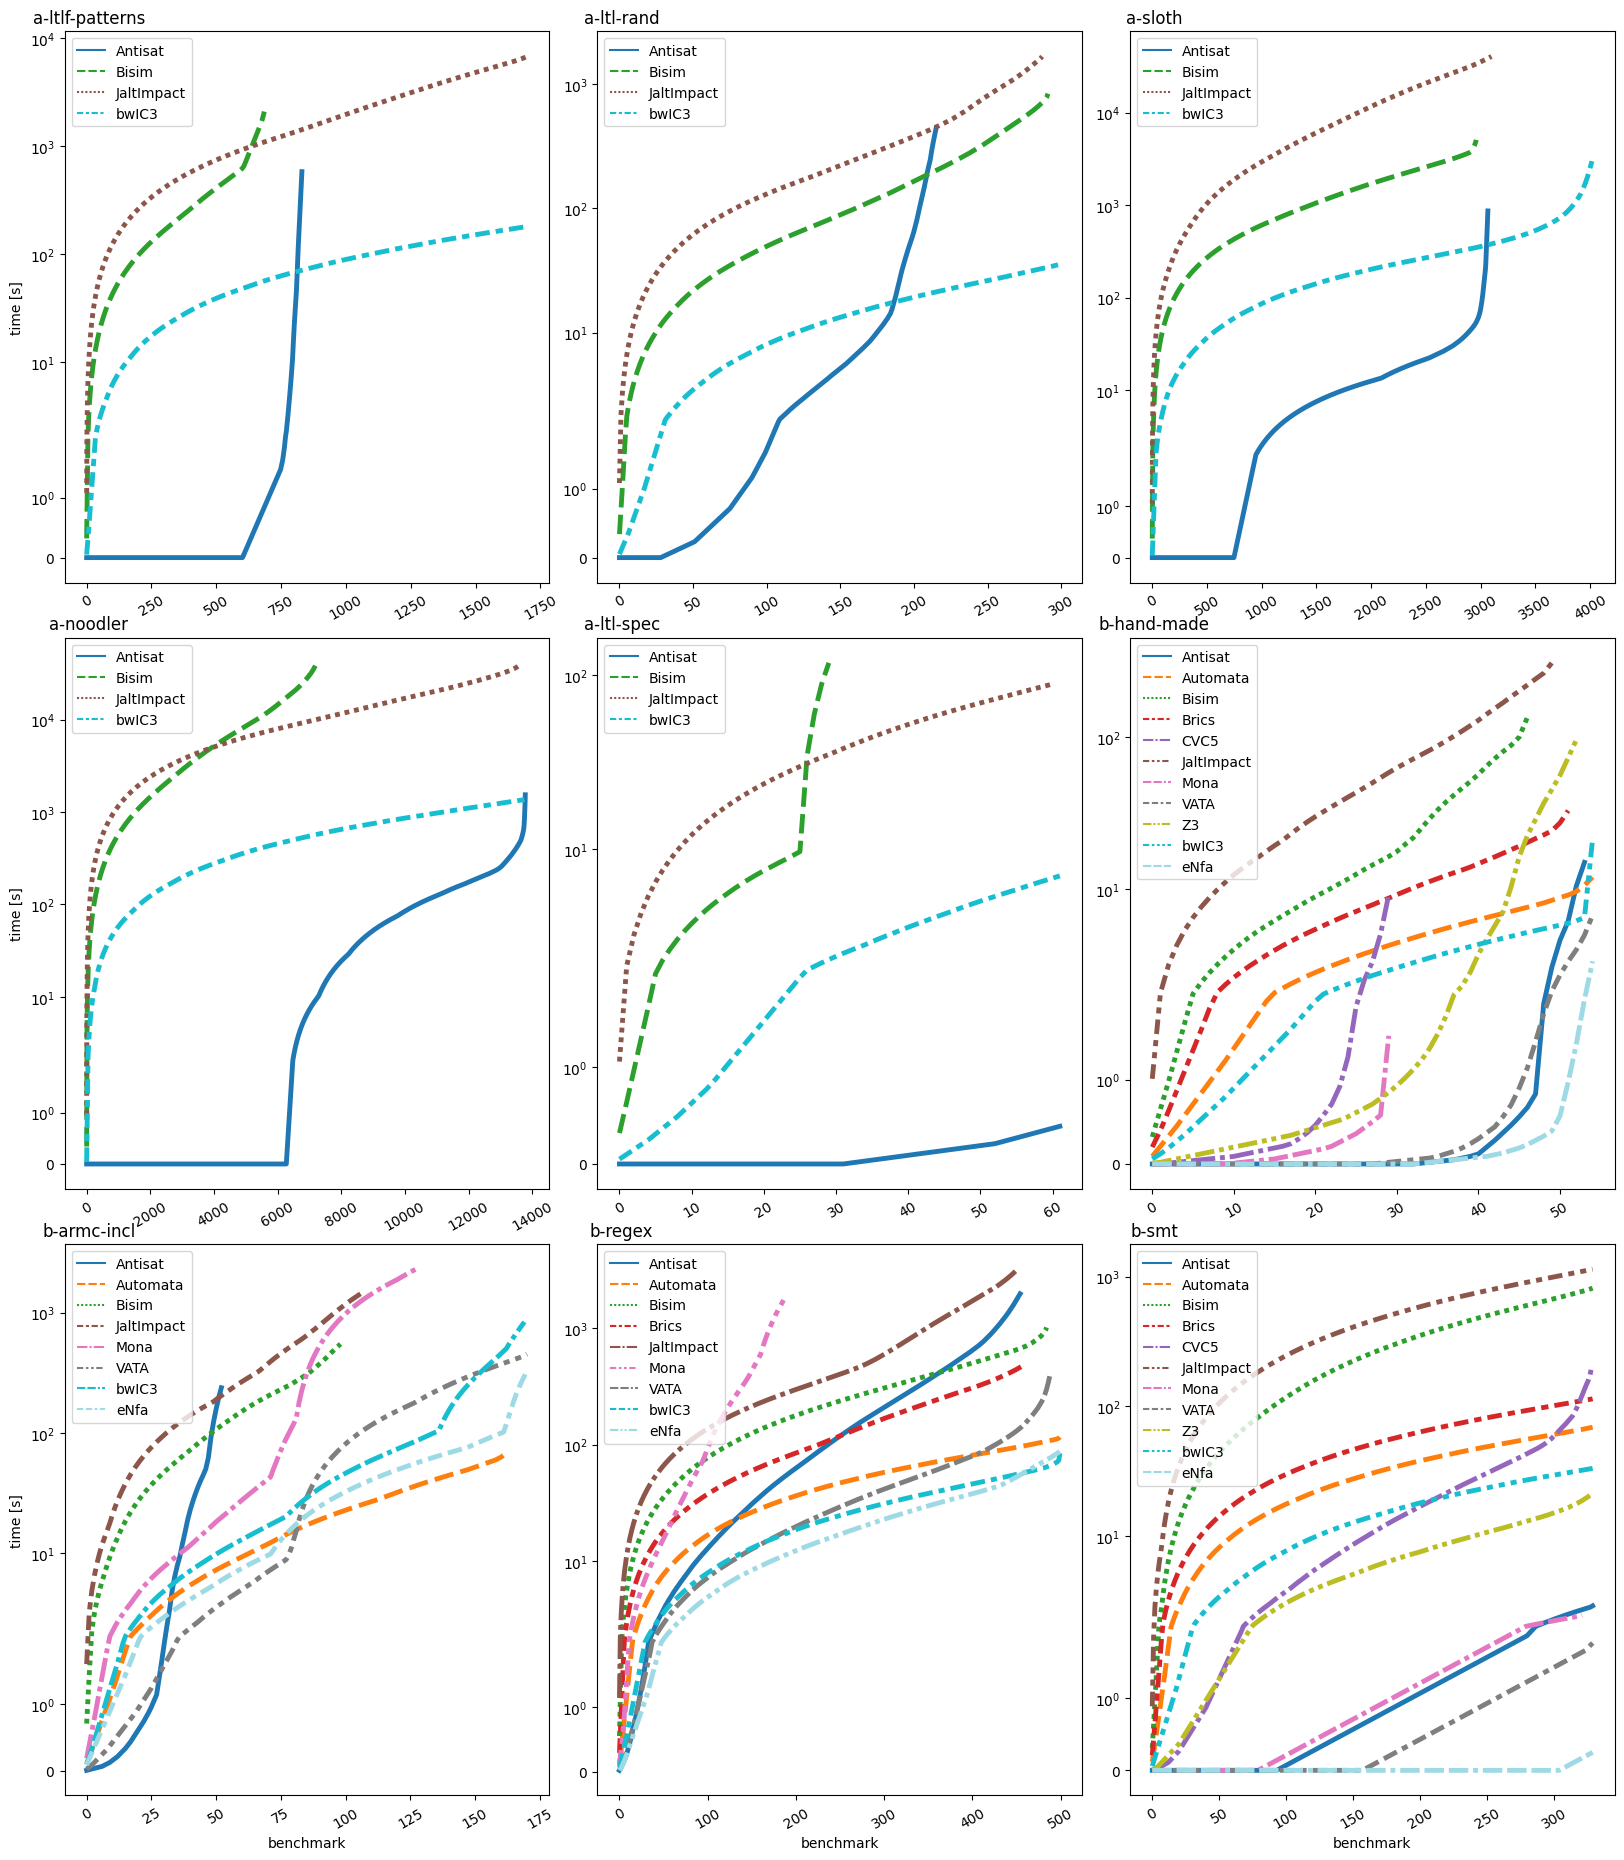

In [9]:
BEST_RATE = 0.2

fig, ax = plt.subplots(3, 3, figsize=(4*5, 3*6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.1)
bench_list = [
    'a-ltlf-patterns', 'a-ltl-rand', 'a-sloth', 'a-noodler', 'a-ltl-spec',  # AFA Benchmarks
    'b-hand-made', 'b-armc-incl', 'b-regex', 'b-smt'                        # BRE Benchmarks
]

for key, pdf in plottable_map_per_grp.items():
    bench, timeout = key.split('#')
    timeout = int(timeout)
    subgroups = set(list(pdf['benchmark']))
    for grp in subgroups:
        data = pdf[pdf['benchmark'] == grp]
        # Parametric benchmarks will be visualized in other way.
        if grp.endswith('-param'):
            continue
        i = bench_list.index(grp)
        sums = defaultdict(list)
        grp_name = f"{grp}"

        # Preprocesses the data to cumulative suns. Filters out those that did not solve
        # at least 20% of benchmarks in given groups
        for _, row in data.iterrows():
            sums[row['tool']].append(row['duration'])
        vdata = {}
        for k in sorted(sums.keys()):
            v = sums[k]
            values = list(sum_generator(sorted(v), timeout))
            val_len = len(values)
            to_len = len([a for a in values if a == None])
            if (val_len - to_len) / val_len > BEST_RATE:
                vdata[k] = values
                
        # Plot is in logarithmic scale
        g = seaborn.lineplot(
            vdata, linewidth=3.5, ax=ax[i // 3, i % 3], palette=color_map
        )
        g.set(yscale="symlog")
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        g.set_title(f"{grp_name}", x=0.05)    
        if i % 3 == 0:
            g.set_ylabel("time [s]")
        if i // 3 == 2:
            g.set_xlabel("benchmark")
        seaborn.move_legend(g, "upper left", bbox_to_anchor=(0., 1), frameon=True)
        i += 1

# Saves figures into `figs/` directory
save_figure(f"cactus")
save_figure(f"cactus", ext=".pdf")

## Infering Parametric models

For two benchmarks `a-param` and `b-param` we created individual models, that models runtime (on `y` axis) based on the value of parameter `k`. Refer to our paper or main site to learn more about the individual families.

In [10]:
columns = ['bench', 'k', 'tool', 'duration']
def to_models(df):
    """Computes models out of @p df"""
    data = []
    for index, row in df.iterrows():
        if 'parametric_ltl' in row['name']:
            bench_parts = row['name'].split(os.sep)
        else:
            bench_parts = os.path.dirname(row['name']).split(os.sep)
        bench = os.path.join(*bench_parts[:3])
        k = bench_parts[-1]
        if is_real(k):
            k = int(k)
            for col, v in row.items():
                if col == 'name':
                    continue
                tool = unify_tool(col)
                if v == 'ERR':
                    time = np.NaN
                elif is_real(v):
                    time = float(v)
                elif v.startswith('TO'):
                    time = int(v[2:])
                else:
                    continue
                data.append([bench, k, tool, time])
    tmp_data = sorted(data, key=lambda x: x[1])
    to_map = defaultdict(list)
    data = []
    for val in tmp_data:
        key = f"{val[0]}:{val[2]}"
        if val[-1] >= 60:
            # it's timeout:
            if not to_map[key] or to_map[key][-1] < 60:
                data.append(val)
        else:
            data.append(val) 
        to_map[key].append(val[-1])
    models = pandas.DataFrame(data, columns=columns)
    return models
for key, df in dataframe_map.items():
    models = to_models(df)

Saving to figs/models.png
Saving to figs/models.pdf


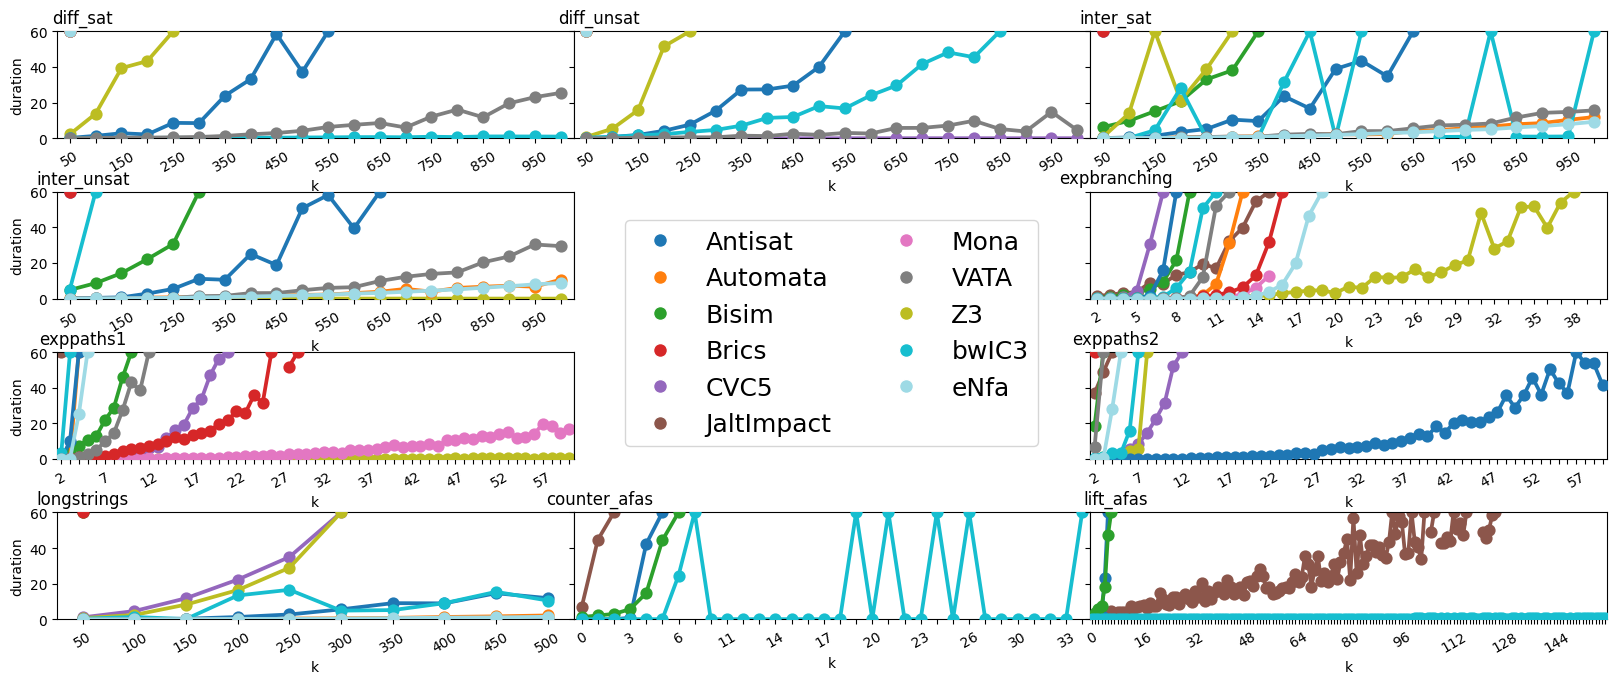

In [11]:
# Mapping of measured benchmarks to names use in paper
bench_to_paper = {
    'bool_comb/intersect/longstrings': 'longstrings',
    'bool_comb/intersect/expbranching': 'expbranching',
    'bool_comb/intersect/exppaths1': "exppaths1",
    'bool_comb/intersect/exppaths2': "exppaths2",
    'bool_comb/cox/diff_sat': "diff_sat",
    'bool_comb/cox/diff_unsat': "diff_unsat",
    'bool_comb/cox/inter_sat': "inter_sat",
    'bool_comb/cox/inter_unsat': "inter_unsat",
    'ltl_afa/created_ltl/LTLf-specific': 'LTLf-specific',
    'ltl_afa/parametric_ltl/lift_afas': 'lift_afas',
    'ltl_afa/parametric_ltl/counter_afas': 'counter_afas',
}


f, axs = plt.subplots(4, 3, figsize=(20, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.0)
i = 0
for key in sorted(dataframe_map.keys()):
    df = dataframe_map[key]
    models = to_models(df)
    for bench in sorted(set(models['bench'])):
        # The following model is skipped as it is not that interesting
        if bench in ('ltl_afa/created_ltl/LTLf-specific',):
            continue
        data_df = models[models['bench'] == bench]
        g = seaborn.pointplot(
            data_df, x="k", y="duration", hue="tool", errorbar=None, 
            ax=axs[i // 3, i % 3], palette=color_map, markers='o',
        )
        g.legend([],[], frameon=False)
        g.set_ylim([0, 60])
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        tick_rate = len(g.get_xticklabels()) // 10
        if tick_rate != 0:
            for index, label in enumerate(g.get_xticklabels()):
                if index % tick_rate == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
        g.set_title(f"{bench_to_paper[bench]}", x=0.05)
        if i % 3 != 0:
            g.set(yticklabels=[])
            g.set(ylabel=None)
        seaborn.move_legend(g, "upper right", bbox_to_anchor=(1, 1), ncols=2)
        # The following are some black magic hacks have the final layout
        i += 1
        if i == 4 or i == 7:
            i += 1
# The following are some black magic hacks have the final layout
i = 4
axs[i // 3, i % 3].set(xlabel=None)
axs[i // 3, i % 3].set(yticklabels=[])
axs[i // 3, i % 3].set(xticklabels=[])
axs[i // 3, i % 3].set(xticks=[])
axs[i // 3, i % 3].set(yticks=[])
axs[i // 3, i % 3].spines['top'].set_visible(False)
axs[i // 3, i % 3].spines['bottom'].set_visible(False)

# The following are some black magic hacks to print the label in the middle
i = 7
axs[i // 3, i % 3].legend(
    handles=[
        Line2D(
            [0], [0], color='w', marker='o', markerfacecolor=color_map[tool], label=f"{tool}", 
            markersize=10,
        )
        for tool in sorted(color_map.keys())
    ], ncols=2, loc='lower center', fontsize='18'
)
axs[i // 3, i % 3].set(xlabel=None)
axs[i // 3, i % 3].set(yticklabels=[])
axs[i // 3, i % 3].set(xticklabels=[])
axs[i // 3, i % 3].set(xticks=[])
axs[i // 3, i % 3].set(yticks=[])
axs[i // 3, i % 3].spines['top'].set_visible(False)
axs[i // 3, i % 3].spines['bottom'].set_visible(False)
save_figure(f'models')
save_figure(f'models', ext='.pdf')

## Scatter plot of winners

For each benchmark we picked three winners and compared each other in scatter plot.

/tmp/ipykernel_4142/378436470.py:22: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.3)


Saving to figs/scatter.png
Saving to figs/scatter.pdf


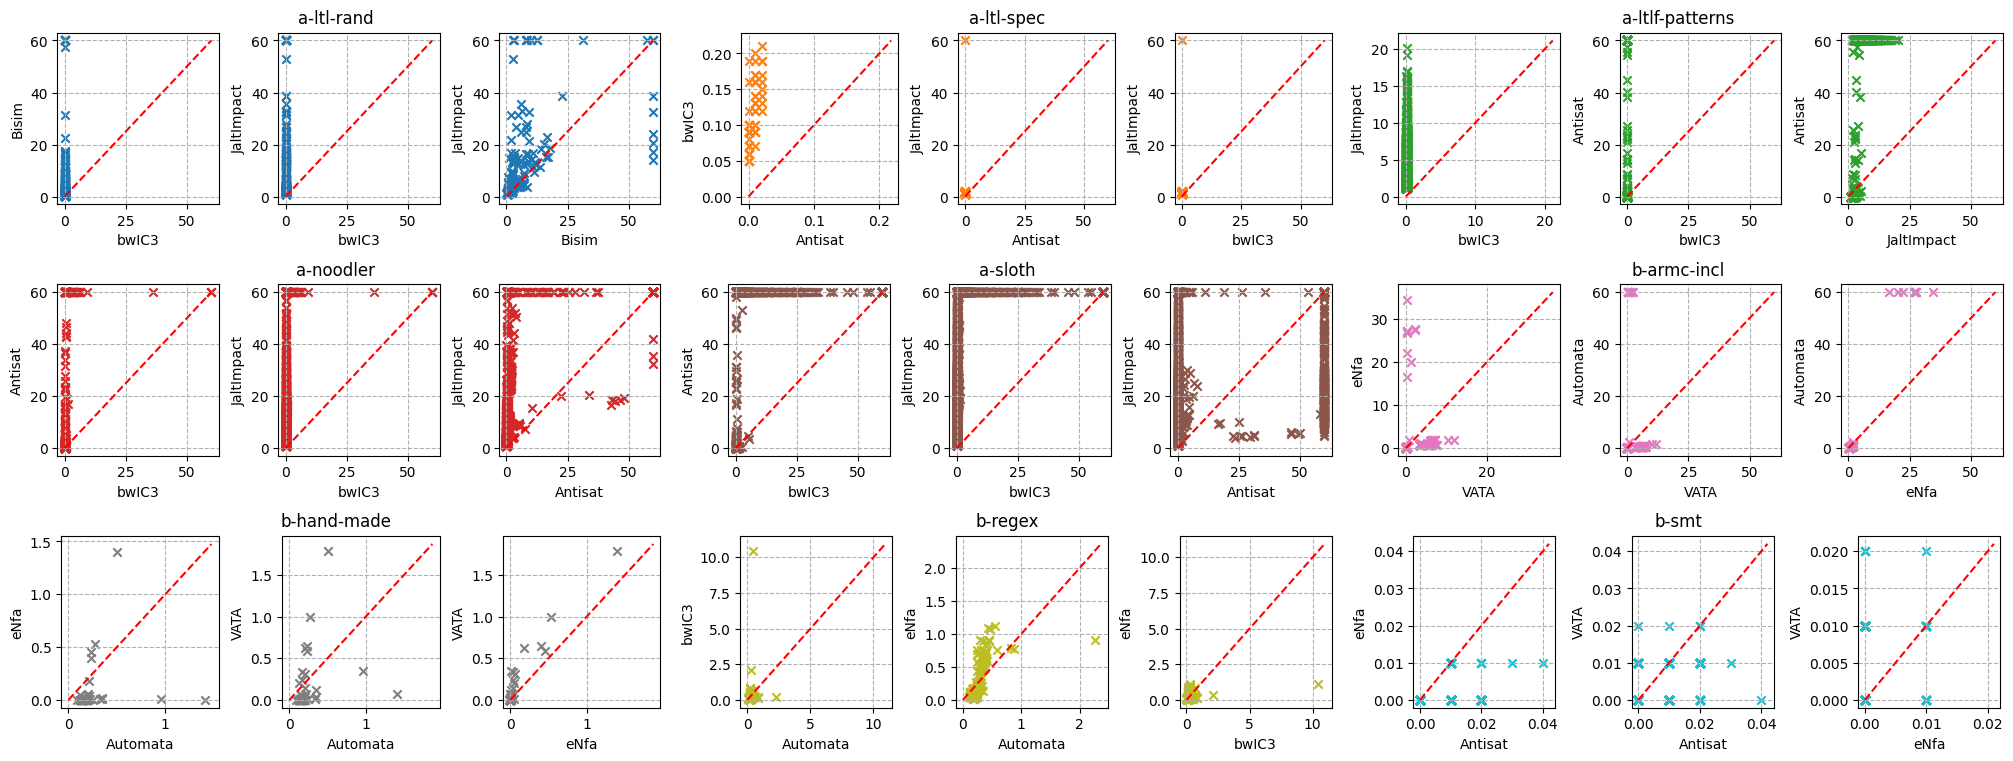

In [12]:
overall_df['bench'] = [get_benchmark_name(n) for n in overall_df['name']]
benches = sorted([b for b in sorted(list(set(overall_df['bench']))) if not b.endswith('-param')])

winners = {
    'a-ltl': ['abc', 'jaltimpact', 'afaminisat-nt'], 
    'a-ltlf-patterns': ['abc', 'jaltimpact', 'afaminisat-nt'], 
    'a-ltl-param': ['abc', 'jaltimpact', 'bisim'], 
    'a-ltl-rand': ['abc', 'bisim', 'jaltimpact'], 
    # 'a-sloth': ['abc', 'afaminisat-nt', 'bisim'], -> skipped as it is less interesting
    'a-sloth': ['abc', 'afaminisat-nt', 'jaltimpact'],
    'a-noodler': ['abc', 'afaminisat-nt', 'jaltimpact'], 
    'a-ltl-spec': ['afaminisat-nt', 'abc', 'jaltimpact'], 
    'b-hand-made': ['automata', 'mata-nfa', 'vata'],
    'b-armc-incl': ['vata', 'mata-nfa', 'automata'], 
    'b-param': ['z3', 'afaminisat-nt', 'vata'],
    'b-regex': ['automata', 'abc', 'mata-nfa'], 
    'b-smt': ['afaminisat-nt', 'mata-nfa', 'vata']
}
indices = [(1, 2), (1, 3), (2, 3)]
bench_colors = mpl.colormaps['tab10'].resampled(len(benches)).colors
fig = plt.figure(constrained_layout=True, figsize=(4*5, 3*2.5))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.3)
subfigs = fig.subfigures(3, 3)
for i, subfig in enumerate(subfigs.flat):
    if i == len(benches):
        break
    subfig.suptitle(f"{benches[i]}")
    axs = subfig.subplots(1, 3)
    bench = benches[i]
    bench_df = df_to_float(overall_df[overall_df['bench'] == bench], 60, allow_timeouts=True)
    for ii, ax in enumerate(axs.flat):
        lhs, rhs = indices[ii]
        lhs, rhs = winners[bench][lhs-1], winners[bench][rhs-1]
        ax.grid(True, which='both', linestyle='--')
        ax.set_xlabel(f"{tool_to_output[lhs]}")
        ax.set_ylabel(f"{tool_to_output[rhs]}")
        ax.scatter(
            bench_df[f"{lhs}-runtime"], bench_df[f"{rhs}-runtime"], marker= 'x', c=[bench_colors[i]]
        )
        pt = min(max(ax.get_xlim()[1], ax.get_ylim()[1]), 60)
        ax.plot([0, pt], [0, pt], linestyle='--', color='red')
save_figure("scatter")
save_figure("scatter", ext=".pdf")
plt.show()

In [13]:
print("Processing experiments complete")

Processing experiments complete
